petgraph review/internals
---------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 11.2019
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/petgraph/petgraph) [ipynb](./petgraph_review.ipynb)

petgraph is a rust library which allows you to work with graph data structures in rust.

In [2]:
:dep petgraph = "0.4.13"
:dep petgraph-evcxr = "*"

Internal representation of graphs by petgraph
------------------------------------------------------------------

Petgraph supports four different internal representations for graphs. The most common one is `Graph` which I have used throughout this tutorial.

- [`Graph`](https://docs.rs/petgraph/0.4.13/petgraph/graph/index.html) 
- [`StableGraph`](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
- [`GraphMap`](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
- [`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)

The `Graph` data structure
--------------------------------------

`Graph`s are stored like this:

```rust
pub struct Graph<N, E, Ty = Directed, Ix = DefaultIx> {
    nodes: Vec<Node<N, Ix>>,
    edges: Vec<Edge<E, Ix>>,
    ty: PhantomData<Ty>,
}
```
...

```rust
pub struct Node<N, Ix = DefaultIx> {
    /// Associated node data.
    pub weight: N,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
}
```
...

```rust
pub struct Edge<E, Ix = DefaultIx> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    node: [NodeIndex<Ix>; 2],
}
```
...

My first impression when looking at this code was "wait which order is the 'outgoing and incoming edge list' so I looked in the source code and found that there is actually an enum which indexes the duple. It can be found in [src/lib.rs](https://github.com/petgraph/petgraph/blob/45e8d931a786f0ab928aff6fa602fab4e418dbb8/src/lib.rs#L123). Yes it Outgoing is first.

```rust
pub enum Direction {
    /// An `Outgoing` edge is an outward edge *from* the current node.
    Outgoing = 0,
    /// An `Incoming` edge is an inbound edge *to* the current node.
    Incoming = 1
}
```

Basically, what is going on, is that each `Node` has two doubly linked lists of `Edge`s associated with it. Now my first question, is how does a `Directed` Graph differ from an `Undirected` one in terms of internal representation?

I could have read the source code to figure that out, but I decided to have fun and instead visualize the datastructure by converting it to a graph.

In [3]:
/*
  In order to visualize the internals we need to make a bunch of fields public.
  We do so via an unsafe cast, refered to as a transumtation in rust.
  This method is described here:
  https://users.rust-lang.org/t/is-private-really-private/7826/15
*/
extern crate petgraph;
use petgraph::*;
use petgraph::dot::Dot;
use petgraph::graph::*;
use petgraph::prelude::*;
use petgraph::data::*;
use std::marker::PhantomData;
use petgraph_evcxr::draw_graph;

pub struct PubNode<N, Ix> {
    pub weight: N,
    pub next: [EdgeIndex<Ix>; 2],
}

pub struct PubEdge<E, Ix = DefaultIx> {
    /// Associated edge data.
    pub weight: E,
    /// Next edge in outgoing and incoming edge lists.
    pub next: [EdgeIndex<Ix>; 2],
    /// Start and End node index
    pub node: [NodeIndex<Ix>; 2],
}

pub struct PubGraph<N, E, Ty = Directed, Ix = DefaultIx> {
    pub nodes: Vec<PubNode<N, Ix>>,
    pub edges: Vec<PubEdge<E, Ix>>,
    pub ty: PhantomData<Ty>,
}

fn visualize_graph_internals<N, E, Ty, Ix>(g: &Graph<N, E, Ty, Ix>) -> Graph<String, String, petgraph::Directed>
    where
        N: std::fmt::Debug + Clone,
        E: std::fmt::Debug + Clone,
        Ty: EdgeType + Clone,
        Ix: std::fmt::Debug + IndexType + Clone,
{
    let mut v: Graph<String, String, petgraph::Directed> = Graph::new();
    let mut _g: Graph<N, E, Ty, Ix> = g.clone();
    let pub_g: PubGraph<N, E, Ty, Ix> = unsafe { std::mem::transmute(_g) };
    let mut nodes: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    let mut edges: Vec<NodeIndex> = vec![NodeIndex::new(0); g.node_count()];
    for node_id in g.node_indices() {
        let w = format!("Node: {:?}", g.node_weight(node_id));
        nodes[node_id.index()] = v.add_node(w.to_string());
    }
    for edge_id in g.edge_indices() {
        let w = format!("Edge: {:?}", g.edge_weight(edge_id));
        edges[edge_id.index()] = v.add_node(w.to_string());
    }
    let mut add_link = |start: NodeIndex, end: usize, collection: Vec<NodeIndex>, label: &str| {
        match collection.get(end) {
            Some(dest) => {
                v.add_edge(start, *dest, label.to_string());
            },
            None => {
                let end_node = v.add_node("end".to_string());
                v.add_edge(start, end_node, label.to_string());
            },
        }
    };
    for (edge, edge_id) in pub_g.edges.iter().zip(g.edge_indices()) {
        let vedge_id = edges[edge_id.index()];
        add_link(vedge_id, edge.node[0].index(), nodes.clone(), "nodes[0]");
        add_link(vedge_id, edge.node[1].index(), nodes.clone(), "nodes[1]");
        add_link(vedge_id, edge.next[0].index(), edges.clone(), "next[0]");
        add_link(vedge_id, edge.next[1].index(), edges.clone(), "next[1]");
    }
    for (node, node_id) in pub_g.nodes.iter().zip(g.node_indices()) {
        let vnode_id = nodes[node_id.index()];
        add_link(vnode_id, node.next[0].index(), edges.clone(), "next[0]");
        add_link(vnode_id, node.next[1].index(), edges.clone(), "next[1]");
    }
    v
}

First lets look at an undirected graph; the `list` example from the previous article.

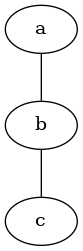

In [4]:
let mut list : Graph<&str, &str, petgraph::Undirected> = Graph::new_undirected();
let item1 = list.add_node("a");
let item2 = list.add_node("b");
let item3 = list.add_node("c");
list.add_edge(item1, item2, "");
list.add_edge(item2, item3, "");
draw_graph(&list);

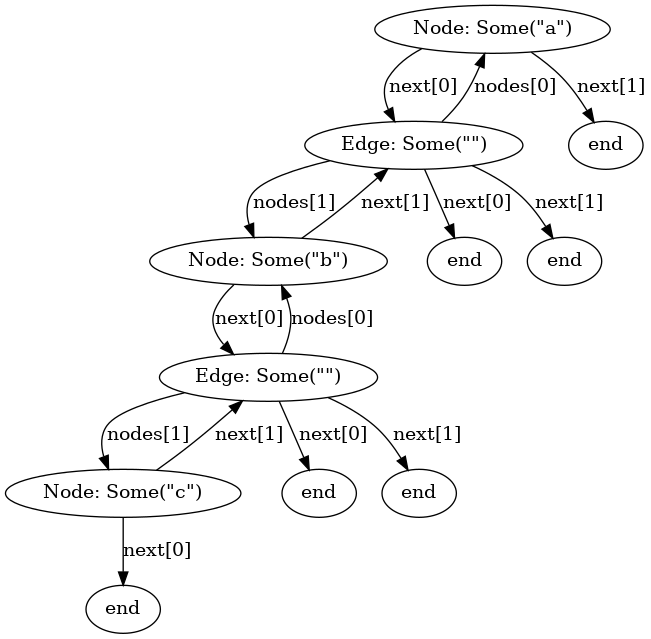

In [5]:
draw_graph(&visualize_graph_internals(&list));

Now lets look at a directed graph. I'll use the `tree` example.

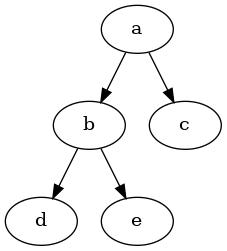

In [6]:
let mut tree : Graph<&str, &str, petgraph::Directed> = Graph::new();
let tree_item1 = tree.add_node("a");
let tree_item2 = tree.add_node("b");
let tree_item3 = tree.add_node("c");
let tree_item4 = tree.add_node("d");
let tree_item5 = tree.add_node("e");
tree.add_edge(tree_item1, tree_item2, "");
tree.add_edge(tree_item1, tree_item3, "");
tree.add_edge(tree_item2, tree_item4, "");
tree.add_edge(tree_item2, tree_item5, "");
draw_graph(&tree);

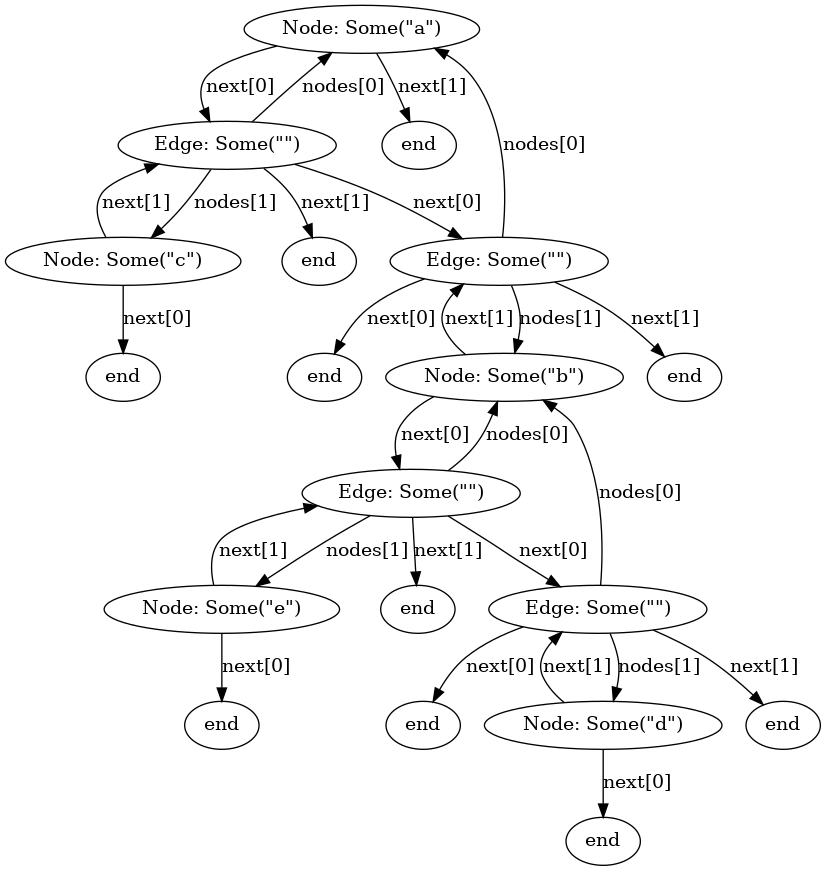

In [7]:
draw_graph(&visualize_graph_internals(&tree));

As you can see, directed and undirected graphs have the exact same internal representation.

To answer a question from earier "how do we convert from a directed to an undirected graph?" We can do so "unsafely" simply by using transmute.

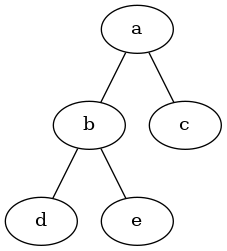

In [8]:
let undirected_tree : Graph<&str, &str, petgraph::Undirected> = unsafe {std::mem::transmute(tree.clone())};
draw_graph(&undirected_tree);

Of course, since we did a transmute and it worked, we know that the representation *should* be the same, lets just verify that.

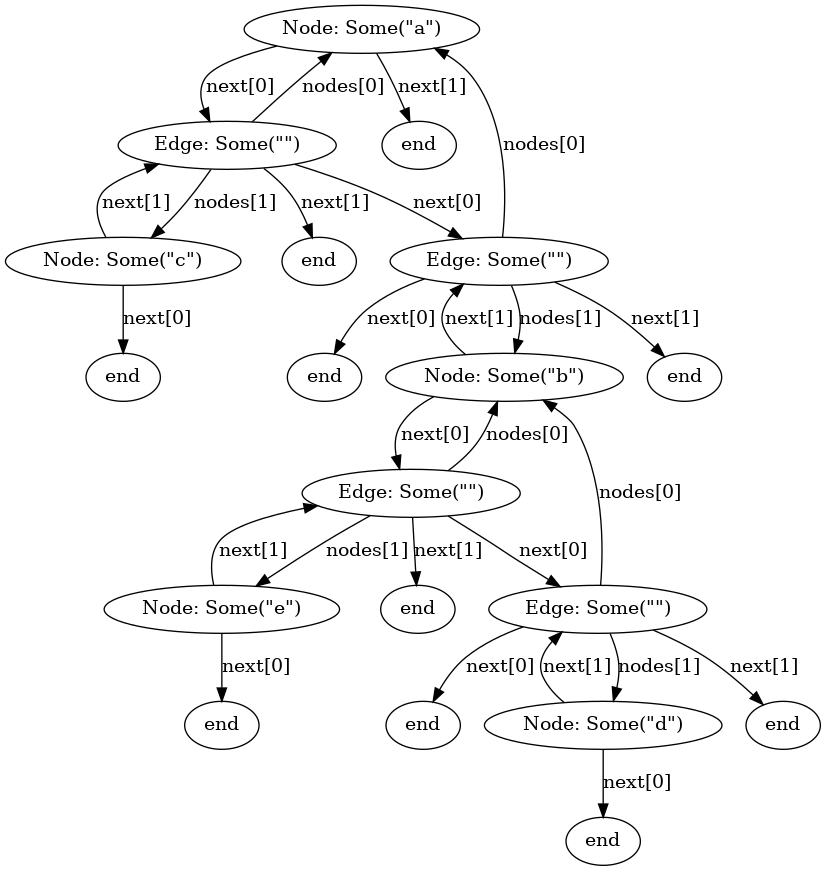

In [9]:
draw_graph(&visualize_graph_internals(&undirected_tree));

[StableGraph](https://docs.rs/petgraph/0.4.13/petgraph/stable_graph/index.html)
------------------

When a node or edge in a `Graph` gets deleted, the `Vec` of nodes/edges is repacked. This means that the indexes of all the nodes and edges which came after that edge in the `Vec` are invalidated. `StableGraph` solves this problem through some rather dirty tricks.

```rust
pub struct StableGraph<N, E, Ty = Directed, Ix = DefaultIx>
{
    g: Graph<Option<N>, Option<E>, Ty, Ix>,
    node_count: usize,
    edge_count: usize,

    // node and edge free lists (both work the same way)
    //
    // free_node, if not NodeIndex::end(), points to a node index
    // that is vacant (after a deletion).  The next item in the list is kept in
    // that Node's Node.next[0] field. For Node, it's a node index stored
    // in an EdgeIndex location, and the _into_edge()/_into_node() methods
    // convert.
    free_node: NodeIndex<Ix>,
    free_edge: EdgeIndex<Ix>,
}
```

When you delete a node in a stable graph, first, it disconnects the edge/node from the graph, then it marks the node/edge weight as `None`. `StableGraph`'s methods which do things such as iterating all nodes, will ignore those who's weights are `None`. `StableGraph` stores a list of such "free" nodes/edges embeded in the graph as described in the comment.

[GraphMap](https://docs.rs/petgraph/0.4.13/petgraph/graphmap/index.html)
---------------

`GraphMap` aims to make it easy and fast to look up Nodes by their weights.

```rust
pub struct GraphMap<N, E, Ty> {
    nodes: OrderMap<N, Vec<(N, CompactDirection)>>,
    edges: OrderMap<(N, N), E>,
    ty: PhantomData<Ty>,
}
```

Unfortunately, it is not a well designed data structure. In most cases is wasteful when it comes to space, time, and it (pointlessly) doesn't support multigraphs. Currently it takes 

```
(4 * size_of::<N>() + size_of::<E>() + 2 * size_of::<CompactDirection>() ) * |E| + size_of::<N>() * |V|
```

space.

A better design would be:

```rust
pub struct Node<N, E> {
    outgoing_edges: Vec<(N, E)>,
    nodes_that_point_here: Vec<N>,
}

pub struct GraphMap<N, E, Ty> {
    nodes: OrderMap<N, Node<N, E>>,
    ty: PhantomData<Ty>,
}
```

This would support multigraphs, it would take at most the same number of OrderMap lookups to resolve an edge weight, but most of the time fewer lookups. It would take the following amount of space:

```
(2 * size_of::<N>() + size_of::<E>() ) * |E| + size_of::<N>() * |V|
```

That said. If `size_of::<N>()` is small, you may find `GraphMap` usefull if you often need to look up Nodes by their node weight.

[`csr`](https://docs.rs/petgraph/0.4.13/petgraph/csr/index.html) (Compressed Sparse Row)
---------------------

